In [1]:
import anndata as ad
import gc
import sys
from scipy.sparse import csc_matrix
from sklearn.model_selection import train_test_split
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LinearRegression
import random
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
import pickle
import heapq
import matplotlib
import os

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
random.seed(1)
np.random.seed(1)
torch.manual_seed(1)

batch_size = 50000
pred_num = 1

cuda


In [3]:
train_mod1_file = 'phase2_private_data/predict_modality/openproblems_bmmc_cite_phase2_rna/openproblems_bmmc_cite_phase2_rna.censor_dataset.output_train_mod1.h5ad'
train_mod2_file = 'phase2_private_data/predict_modality/openproblems_bmmc_cite_phase2_rna/openproblems_bmmc_cite_phase2_rna.censor_dataset.output_train_mod2.h5ad'
test_mod1_file = 'phase2_private_data/predict_modality/openproblems_bmmc_cite_phase2_rna/openproblems_bmmc_cite_phase2_rna.censor_dataset.output_test_mod1.h5ad'
test_mod2_file = 'phase2_private_data/predict_modality/openproblems_bmmc_cite_phase2_rna/openproblems_bmmc_cite_phase2_rna.censor_dataset.output_test_mod2.h5ad'

In [4]:
input_train_mod1 = ad.read_h5ad(train_mod1_file)
input_train_mod2 = ad.read_h5ad(train_mod2_file)
input_test_mod1 = ad.read_h5ad(test_mod1_file)
input_test_mod2 = ad.read_h5ad(test_mod2_file)

In [5]:
print(input_train_mod1)
print(input_train_mod2)
print(input_test_mod1)
print(input_test_mod2)

AnnData object with n_obs × n_vars = 66175 × 13953
    obs: 'batch', 'size_factors'
    var: 'gene_ids', 'feature_types'
    uns: 'dataset_id', 'organism'
    layers: 'counts'
AnnData object with n_obs × n_vars = 66175 × 134
    obs: 'batch', 'size_factors'
    var: 'feature_types'
    uns: 'dataset_id', 'organism'
    layers: 'counts'
AnnData object with n_obs × n_vars = 1000 × 13953
    obs: 'batch', 'size_factors'
    var: 'gene_ids', 'feature_types'
    uns: 'dataset_id', 'organism'
    layers: 'counts'
AnnData object with n_obs × n_vars = 1000 × 134
    obs: 'batch', 'size_factors'
    var: 'feature_types'
    uns: 'dataset_id', 'organism'
    layers: 'counts'


In [6]:
print(sorted(set(input_train_mod1.obs['batch'])))
print(sorted(set(input_train_mod2.obs['batch'])))

['s1d1', 's1d2', 's1d3', 's2d1', 's2d4', 's2d5', 's3d1', 's3d6', 's3d7']
['s1d1', 's1d2', 's1d3', 's2d1', 's2d4', 's2d5', 's3d1', 's3d6', 's3d7']


In [7]:
print(sorted(set(input_test_mod1.obs['batch'])))
print(sorted(set(input_test_mod2.obs['batch'])))

['s4d1', 's4d8', 's4d9']
['s4d1', 's4d8', 's4d9']


In [8]:
RNA_s1d1 = input_train_mod1[input_train_mod1.obs["batch"] == "s1d1", :]
RNA_s1d2 = input_train_mod1[input_train_mod1.obs["batch"] == "s1d2", :]
RNA_s1d3 = input_train_mod1[input_train_mod1.obs["batch"] == "s1d3", :]
RNA_s2d1 = input_train_mod1[input_train_mod1.obs["batch"] == "s2d1", :]
RNA_s2d4 = input_train_mod1[input_train_mod1.obs["batch"] == "s2d4", :]
RNA_s2d5 = input_train_mod1[input_train_mod1.obs["batch"] == "s2d5", :]

RNA_s3d1 = input_train_mod1[input_train_mod1.obs["batch"] == "s3d1", :]
RNA_s3d6 = input_train_mod1[input_train_mod1.obs["batch"] == "s3d6", :]
RNA_s3d7 = input_train_mod1[input_train_mod1.obs["batch"] == "s3d7", :]

In [9]:
pro_s1d1 = input_train_mod2[input_train_mod2.obs["batch"] == "s1d1", :]
pro_s1d2 = input_train_mod2[input_train_mod2.obs["batch"] == "s1d2", :]
pro_s1d3 = input_train_mod2[input_train_mod2.obs["batch"] == "s1d3", :]
pro_s2d1 = input_train_mod2[input_train_mod2.obs["batch"] == "s2d1", :]
pro_s2d4 = input_train_mod2[input_train_mod2.obs["batch"] == "s2d4", :]
pro_s2d5 = input_train_mod2[input_train_mod2.obs["batch"] == "s2d5", :]

pro_s3d1 = input_train_mod2[input_train_mod2.obs["batch"] == "s3d1", :]
pro_s3d6 = input_train_mod2[input_train_mod2.obs["batch"] == "s3d6", :]
pro_s3d7 = input_train_mod2[input_train_mod2.obs["batch"] == "s3d7", :]

In [10]:
RNA_s4d1 = input_test_mod1[input_test_mod1.obs["batch"] == "s4d1", :]
RNA_s4d8 = input_test_mod1[input_test_mod1.obs["batch"] == "s4d8", :]
RNA_s4d9 = input_test_mod1[input_test_mod1.obs["batch"] == "s4d9", :]

In [11]:
pro_s4d1 = input_test_mod2[input_test_mod2.obs["batch"] == "s4d1", :]
pro_s4d8 = input_test_mod2[input_test_mod2.obs["batch"] == "s4d8", :]
pro_s4d9 = input_test_mod2[input_test_mod2.obs["batch"] == "s4d9", :]

In [12]:
RNA_s1d1 = RNA_s1d1.X.toarray()
RNA_s1d2 = RNA_s1d2.X.toarray()
RNA_s1d3 = RNA_s1d3.X.toarray()
RNA_s2d1 = RNA_s2d1.X.toarray()
RNA_s2d4 = RNA_s2d4.X.toarray()
RNA_s2d5 = RNA_s2d5.X.toarray()

RNA_s3d1 = RNA_s3d1.X.toarray()
RNA_s3d6 = RNA_s3d6.X.toarray()
RNA_s3d7 = RNA_s3d7.X.toarray()

In [13]:
pro_s1d1 = pro_s1d1.X.toarray()
pro_s1d2 = pro_s1d2.X.toarray()
pro_s1d3 = pro_s1d3.X.toarray()
pro_s2d1 = pro_s2d1.X.toarray()
pro_s2d4 = pro_s2d4.X.toarray()
pro_s2d5 = pro_s2d5.X.toarray()

pro_s3d1 = pro_s3d1.X.toarray()
pro_s3d6 = pro_s3d6.X.toarray()
pro_s3d7 = pro_s3d7.X.toarray()

In [14]:
RNA_s4d1 = RNA_s4d1.X.toarray()
RNA_s4d8 = RNA_s4d8.X.toarray()
RNA_s4d9 = RNA_s4d9.X.toarray()

In [15]:
pro_s4d1 = pro_s4d1.X.toarray()
pro_s4d8 = pro_s4d8.X.toarray()
pro_s4d9 = pro_s4d9.X.toarray()

In [16]:
print(RNA_s1d1.shape)
print(pro_s1d1.shape)

(4721, 13953)
(4721, 134)


In [17]:
print(RNA_s4d1.shape)
print(pro_s4d1.shape)

(334, 13953)
(334, 134)


In [18]:
batch_s1d1 = input_train_mod1[input_train_mod1.obs["batch"] == "s1d1", :].obs["batch"]
batch_s1d2 = input_train_mod1[input_train_mod1.obs["batch"] == "s1d2", :].obs["batch"]
batch_s1d3 = input_train_mod1[input_train_mod1.obs["batch"] == "s1d3", :].obs["batch"]
batch_s2d1 = input_train_mod1[input_train_mod1.obs["batch"] == "s2d1", :].obs["batch"]
batch_s2d4 = input_train_mod1[input_train_mod1.obs["batch"] == "s2d4", :].obs["batch"]
batch_s2d5 = input_train_mod1[input_train_mod1.obs["batch"] == "s2d5", :].obs["batch"]

batch_s3d1 = input_train_mod1[input_train_mod1.obs["batch"] == "s3d1", :].obs["batch"]
batch_s3d6 = input_train_mod1[input_train_mod1.obs["batch"] == "s3d6", :].obs["batch"]
batch_s3d7 = input_train_mod1[input_train_mod1.obs["batch"] == "s3d7", :].obs["batch"]

batch_s4d1 = input_test_mod1[input_test_mod1.obs["batch"] == "s4d1", :].obs["batch"]
batch_s4d8 = input_test_mod1[input_test_mod1.obs["batch"] == "s4d8", :].obs["batch"]
batch_s4d9 = input_test_mod1[input_test_mod1.obs["batch"] == "s4d9", :].obs["batch"]

In [19]:
batch_train = list(batch_s1d1)+list(batch_s1d2)+list(batch_s1d3)+list(batch_s2d1)+list(batch_s2d4)+list(batch_s2d5)
batch_val = list(batch_s3d1)+list(batch_s3d6)+list(batch_s3d7)
batch_test = list(batch_s4d1)+list(batch_s4d8)+list(batch_s4d9)

In [20]:
train_input = [RNA_s1d1, RNA_s1d2, RNA_s1d3, RNA_s2d1, RNA_s2d4, RNA_s2d5]
train_output = [pro_s1d1, pro_s1d2, pro_s1d3, pro_s2d1, pro_s2d4, pro_s2d5]

val_input = [RNA_s3d1, RNA_s3d6, RNA_s3d7]
val_output = [pro_s3d1, pro_s3d6, pro_s3d7]

test_input = [RNA_s4d1, RNA_s4d8, RNA_s4d9]
test_output = [pro_s4d1, pro_s4d8, pro_s4d9]

In [21]:
train_input = train_input + val_input
train_output = train_output + val_output

In [22]:
train_input = np.concatenate(train_input, axis=0)
val_input = np.concatenate(val_input, axis=0)
test_input = np.concatenate(test_input, axis=0)

train_output = np.concatenate(train_output, axis=0)
val_output = np.concatenate(val_output, axis=0)
test_output = np.concatenate(test_output, axis=0)

In [23]:
train_input = torch.from_numpy(train_input)
train_output = torch.from_numpy(train_output)
val_input = torch.from_numpy(val_input)
val_output = torch.from_numpy(val_output)
test_input = torch.from_numpy(test_input)
test_output = torch.from_numpy(test_output)

In [24]:
train_input = train_input.float()
train_output = train_output.float()
val_input = val_input.float()
val_output = val_output.float()
test_input = test_input.float()
test_output = test_output.float()

In [25]:
train_input = train_input.to(device)
train_output = train_output.to(device)
val_input = val_input.to(device)
val_output = val_output.to(device)
test_input = test_input.to(device)
test_output = test_output.to(device)

In [26]:
colors = ['red','green','blue','purple', 'yellow', 'orange']
k = 0
batch_lib = {}
for i in range(len(batch_train)):
    if batch_train[i] not in batch_lib:
        k = k + 1
        batch_lib[batch_train[i]] = k
    batch_train[i] = batch_lib[batch_train[i]]

In [27]:
colors = ['red','green','blue','purple', 'yellow', 'orange']
k = 0
batch_lib = {}
for i in range(len(batch_val)):
    if batch_val[i] not in batch_lib:
        k = k + 1
        batch_lib[batch_val[i]] = k
    batch_val[i] = batch_lib[batch_val[i]]

In [28]:
colors = ['red','green','blue','purple', 'yellow', 'orange']
k = 0
batch_lib = {}
for i in range(len(batch_test)):
    if batch_test[i] not in batch_lib:
        k = k + 1
        batch_lib[batch_test[i]] = k
    batch_test[i] = batch_lib[batch_test[i]]

In [29]:
batch_train = batch_train + batch_val

In [30]:
# train_output = train_output[:, 0:pred_num]
# train_output.shape

# val_output = val_output[:, 0:pred_num]
# val_output.shape

# test_output = test_output[:, 0:pred_num]
# test_output.shape

In [31]:
train_ds = TensorDataset(train_input, train_output)
train_dl = DataLoader(train_ds, batch_size= batch_size, shuffle=True)

In [32]:
input_feature = train_input.shape[1]
output_feature = pred_num

In [33]:
# auto-encoder model
# base model
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.linear1 = nn.Linear(input_feature, input_feature//16)
        self.linear2 = nn.Linear(input_feature//2, input_feature//4)
        self.linear3 = nn.Linear(input_feature//4, input_feature//8)
        self.linear4 = nn.Linear(input_feature//8, input_feature//16)
        
        self.linear5 = nn.Linear(input_feature//16, pred_num)
        self.relu = nn.ReLU()
        self.leakyrelu = nn.LeakyReLU(0.1)
        self.dropout = nn.Dropout(0.15)
        
        self.linear = nn.Linear(input_feature, 1)

    def forward(self, x):
        x = self.linear1(x)
        x = self.relu(x)
        # x = self.dropout(x)
        
#         x = self.linear2(x)
#         x = self.relu(x)
#         x = self.dropout(x)
        
#         x = self.linear3(x)
#         x = self.relu(x)
        
#         x = self.linear4(x)
#         x = self.relu(x)
        
        output = self.linear5(x)
        
        return output.float()

In [34]:
PATH = 'No_norm_model_RNA_pro'

In [35]:
def fit(num_epochs, model, loss_fn, protein, train_input, train_output, val_input, val_output, test_input, test_output):
    temp = []
    val_best = float('inf')
    test_best = float('inf')
    train_pred_output = []
    val_pred_output = []
    for epoch in range(num_epochs):
        for x,y in train_dl:
            model = model.train()
            pred = model(x)
            # print(y.shape, pred.shape)
            # y = torch.reshape(y, (y.shape[0], 1))
            loss = loss_fn(pred, y[:, protein:protein+1])
            loss.backward()
            opt.step()
            opt.zero_grad()

        if epoch % 500 == 0:
            model = model.eval()
            
            train_pred = model(train_input)
            # train_output = torch.reshape(train_output, (train_output.shape[0], 1))
            train_loss = loss_fn(train_pred, train_output[:, protein:protein+1])
            train_loss = torch.sqrt(train_loss)
            train_loss = train_loss.cpu().detach().numpy()
            
            val_pred = model(val_input)
            val_loss = loss_fn(val_pred, val_output[:, protein:protein+1])
            val_loss = torch.sqrt(val_loss)
            val_loss = val_loss.cpu().detach().numpy()
            
            test_pred = model(test_input)
            test_loss = loss_fn(test_pred, test_output[:, protein:protein+1])
            test_loss = torch.sqrt(test_loss)
            test_loss = test_loss.cpu().detach().numpy()
            
#             if val_loss < val_best:
#                 torch.save(model.state_dict(), PATH)
#                 val_best = val_loss
            if test_loss < test_best:
                temp = [train_loss, val_loss, test_loss]
                test_best = test_loss
                
            print('Epoch ', epoch, 'Train_loss: ', train_loss, ' Validation_loss: ', val_loss, ' Test_loss: ', test_loss)
        if epoch == 9999:
            colors = ['red','green','blue','purple', 'yellow', 'orange']
            figure, ax = plt.subplots(1, 3, figsize = (10, 4*1))
            for i in range(1):
                ax[0].scatter(train_output.cpu().detach().numpy()[:, 0], train_pred.cpu().detach().numpy()[:, 0], c=batch_train, cmap=matplotlib.colors.ListedColormap(colors), s = 30, alpha=0.3)
                ax[0].plot([-1.5, 3], [-1.5, 3], 'k-')
                ax[0].set_title('Train data result ' + str(i+1))
                ax[0].set_xlabel('train')
                ax[0].set_ylabel('pred')

                ax[1].scatter(val_output.cpu().detach().numpy()[:, 0], val_pred.cpu().detach().numpy()[:, 0], c=batch_val, cmap=matplotlib.colors.ListedColormap(colors), s = 30, alpha=0.3)
                ax[1].plot([-1.5, 3], [-1.5, 3], 'k-')
                ax[1].set_title('Validation data result ' + str(i+1))
                ax[1].set_xlabel('true')
                ax[1].set_ylabel('pred')

                ax[2].scatter(test_output.cpu().detach().numpy()[:, 0], test_pred.cpu().detach().numpy()[:, 0], c=batch_test, cmap=matplotlib.colors.ListedColormap(colors), s = 30, alpha=0.3)
                ax[2].plot([-1.5, 3], [-1.5, 3], 'k-')
                ax[2].set_title('Test data result ' + str(i+1))
                ax[2].set_xlabel('true')
                ax[2].set_ylabel('pred')
            plt.show()
    return temp

In [36]:
num_epochs = 10000
learning_rate = 0.001
loss_fn = F.mse_loss
batch_size = 50000

def seed_everything(seed=1234):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_everything()

Processing protein 0
Epoch  0 Train_loss:  0.32369757  Validation_loss:  0.26562572  Test_loss:  0.32318315
Epoch  500 Train_loss:  0.19816911  Validation_loss:  0.19954635  Test_loss:  0.18379152
Epoch  1000 Train_loss:  0.18803315  Validation_loss:  0.19107158  Test_loss:  0.1790598
Epoch  1500 Train_loss:  0.18000591  Validation_loss:  0.18404584  Test_loss:  0.17825727
Epoch  2000 Train_loss:  0.17237213  Validation_loss:  0.17729867  Test_loss:  0.17962284
Epoch  2500 Train_loss:  0.16466813  Validation_loss:  0.17027418  Test_loss:  0.1824492
Epoch  3000 Train_loss:  0.15675844  Validation_loss:  0.16292016  Test_loss:  0.18614475
Epoch  3500 Train_loss:  0.14860903  Validation_loss:  0.15515181  Test_loss:  0.19012967
Epoch  4000 Train_loss:  0.14016041  Validation_loss:  0.14699961  Test_loss:  0.1941671
Epoch  4500 Train_loss:  0.131468  Validation_loss:  0.13841541  Test_loss:  0.1978925
Epoch  5000 Train_loss:  0.12263367  Validation_loss:  0.1295971  Test_loss:  0.20150799


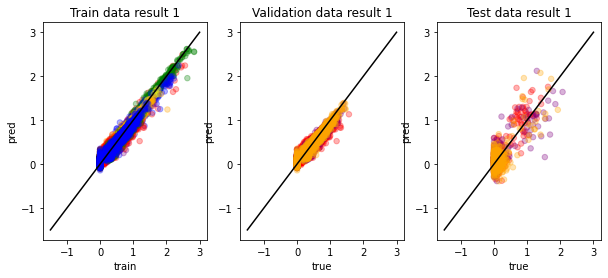

Processing protein 1
Epoch  0 Train_loss:  0.4966762  Validation_loss:  0.3361917  Test_loss:  0.6383083
Epoch  500 Train_loss:  0.3400935  Validation_loss:  0.27411824  Test_loss:  0.63101304
Epoch  1000 Train_loss:  0.3142538  Validation_loss:  0.26103234  Test_loss:  0.6443255
Epoch  1500 Train_loss:  0.28976643  Validation_loss:  0.24562094  Test_loss:  0.651253
Epoch  2000 Train_loss:  0.26395273  Validation_loss:  0.22689824  Test_loss:  0.6668319
Epoch  2500 Train_loss:  0.23671402  Validation_loss:  0.20639998  Test_loss:  0.673346
Epoch  3000 Train_loss:  0.20865183  Validation_loss:  0.18465851  Test_loss:  0.672756
Epoch  3500 Train_loss:  0.18092102  Validation_loss:  0.16196325  Test_loss:  0.68393844
Epoch  4000 Train_loss:  0.15483469  Validation_loss:  0.1404943  Test_loss:  0.6885869
Epoch  4500 Train_loss:  0.13122565  Validation_loss:  0.12090643  Test_loss:  0.6896709
Epoch  5000 Train_loss:  0.11074671  Validation_loss:  0.10402774  Test_loss:  0.68150294
Epoch  55

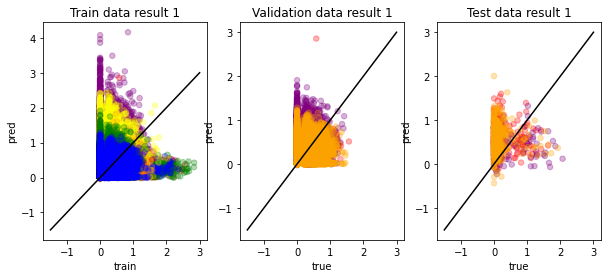

Processing protein 2
Epoch  0 Train_loss:  0.48867503  Validation_loss:  0.5927074  Test_loss:  0.3635085
Epoch  500 Train_loss:  0.276364  Validation_loss:  0.27350402  Test_loss:  0.21250081
Epoch  1000 Train_loss:  0.26191515  Validation_loss:  0.2581906  Test_loss:  0.21643828
Epoch  1500 Train_loss:  0.25066  Validation_loss:  0.24745296  Test_loss:  0.22154067
Epoch  2000 Train_loss:  0.23913962  Validation_loss:  0.23665275  Test_loss:  0.22679758
Epoch  2500 Train_loss:  0.22640291  Validation_loss:  0.22430238  Test_loss:  0.23495455
Epoch  3000 Train_loss:  0.21224882  Validation_loss:  0.21080953  Test_loss:  0.24227111
Epoch  3500 Train_loss:  0.19667052  Validation_loss:  0.19572954  Test_loss:  0.25134405
Epoch  4000 Train_loss:  0.17996006  Validation_loss:  0.179729  Test_loss:  0.25854406
Epoch  4500 Train_loss:  0.16261548  Validation_loss:  0.16297454  Test_loss:  0.2661602
Epoch  5000 Train_loss:  0.14522858  Validation_loss:  0.14625272  Test_loss:  0.2725424
Epoch

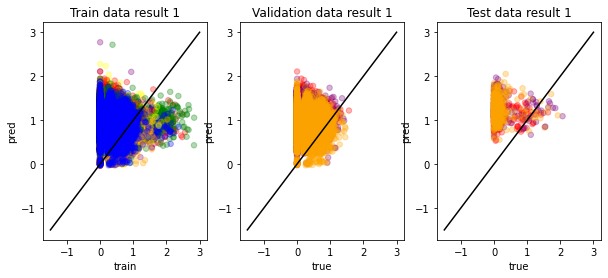

Processing protein 3
Epoch  0 Train_loss:  0.29041624  Validation_loss:  0.29197595  Test_loss:  0.21490051
Epoch  500 Train_loss:  0.21655115  Validation_loss:  0.22716774  Test_loss:  0.17626922
Epoch  1000 Train_loss:  0.20897998  Validation_loss:  0.2203065  Test_loss:  0.1795713
Epoch  1500 Train_loss:  0.20188224  Validation_loss:  0.21360643  Test_loss:  0.18317463
Epoch  2000 Train_loss:  0.19435637  Validation_loss:  0.20624702  Test_loss:  0.18703645
Epoch  2500 Train_loss:  0.18610987  Validation_loss:  0.19802544  Test_loss:  0.19097139
Epoch  3000 Train_loss:  0.17698151  Validation_loss:  0.18876497  Test_loss:  0.1953382
Epoch  3500 Train_loss:  0.16698635  Validation_loss:  0.17853242  Test_loss:  0.20013775
Epoch  4000 Train_loss:  0.15619197  Validation_loss:  0.1674056  Test_loss:  0.20446897
Epoch  4500 Train_loss:  0.1447873  Validation_loss:  0.15555835  Test_loss:  0.20878027
Epoch  5000 Train_loss:  0.1330763  Validation_loss:  0.14334752  Test_loss:  0.21299993

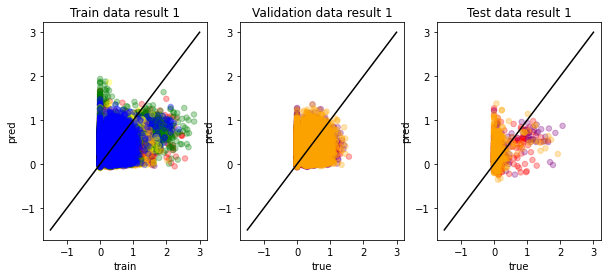

Processing protein 4
Epoch  0 Train_loss:  0.51054335  Validation_loss:  0.5909422  Test_loss:  0.42086908
Epoch  500 Train_loss:  0.28994852  Validation_loss:  0.2858551  Test_loss:  0.26524982
Epoch  1000 Train_loss:  0.27258494  Validation_loss:  0.27096117  Test_loss:  0.27139786
Epoch  1500 Train_loss:  0.25711554  Validation_loss:  0.257217  Test_loss:  0.27904248
Epoch  2000 Train_loss:  0.24119338  Validation_loss:  0.2426224  Test_loss:  0.28809577
Epoch  2500 Train_loss:  0.22423568  Validation_loss:  0.22689003  Test_loss:  0.29742312
Epoch  3000 Train_loss:  0.20624024  Validation_loss:  0.20981264  Test_loss:  0.3061615
Epoch  3500 Train_loss:  0.18724819  Validation_loss:  0.1917498  Test_loss:  0.31394336
Epoch  4000 Train_loss:  0.16815427  Validation_loss:  0.17306483  Test_loss:  0.32074034
Epoch  4500 Train_loss:  0.14923783  Validation_loss:  0.15480554  Test_loss:  0.32628986
Epoch  5000 Train_loss:  0.13139983  Validation_loss:  0.13724256  Test_loss:  0.33117068


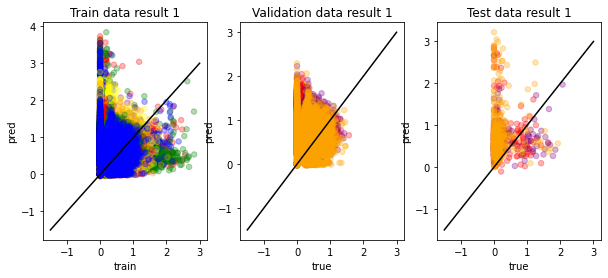

Processing protein 5
Epoch  0 Train_loss:  0.79828495  Validation_loss:  0.4984726  Test_loss:  0.903532
Epoch  500 Train_loss:  0.3777573  Validation_loss:  0.34594038  Test_loss:  0.48879907
Epoch  1000 Train_loss:  0.34609392  Validation_loss:  0.32181823  Test_loss:  0.4985794
Epoch  1500 Train_loss:  0.31887206  Validation_loss:  0.29860675  Test_loss:  0.505122
Epoch  2000 Train_loss:  0.29102692  Validation_loss:  0.27519947  Test_loss:  0.51211596
Epoch  2500 Train_loss:  0.26161993  Validation_loss:  0.2503974  Test_loss:  0.5194628
Epoch  3000 Train_loss:  0.23246224  Validation_loss:  0.22554955  Test_loss:  0.52883446
Epoch  3500 Train_loss:  0.20058106  Validation_loss:  0.19510292  Test_loss:  0.5302735
Epoch  4000 Train_loss:  0.19577572  Validation_loss:  0.19045423  Test_loss:  0.55230963
Epoch  4500 Train_loss:  0.15023123  Validation_loss:  0.15021476  Test_loss:  0.5356819
Epoch  5000 Train_loss:  0.18913054  Validation_loss:  0.17420863  Test_loss:  0.5768856
Epoch

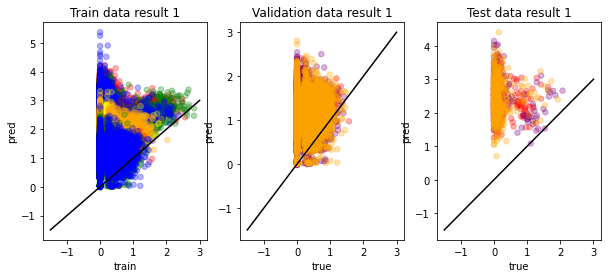

Processing protein 6
Epoch  0 Train_loss:  0.874042  Validation_loss:  0.5618496  Test_loss:  0.85613066
Epoch  500 Train_loss:  0.36886176  Validation_loss:  0.3480929  Test_loss:  0.5012582
Epoch  1000 Train_loss:  0.34353203  Validation_loss:  0.32738578  Test_loss:  0.507585
Epoch  1500 Train_loss:  0.3212309  Validation_loss:  0.30763426  Test_loss:  0.5149593
Epoch  2000 Train_loss:  0.29731965  Validation_loss:  0.28623566  Test_loss:  0.521564
Epoch  2500 Train_loss:  0.27059567  Validation_loss:  0.26165825  Test_loss:  0.52553433
Epoch  3000 Train_loss:  0.24153641  Validation_loss:  0.23564062  Test_loss:  0.5305286
Epoch  3500 Train_loss:  0.2103667  Validation_loss:  0.20574285  Test_loss:  0.5326748
Epoch  4000 Train_loss:  0.19241689  Validation_loss:  0.1912218  Test_loss:  0.5456457
Epoch  4500 Train_loss:  0.16648953  Validation_loss:  0.1596843  Test_loss:  0.53915924
Epoch  5000 Train_loss:  0.14481716  Validation_loss:  0.1471561  Test_loss:  0.5384591
Epoch  5500 

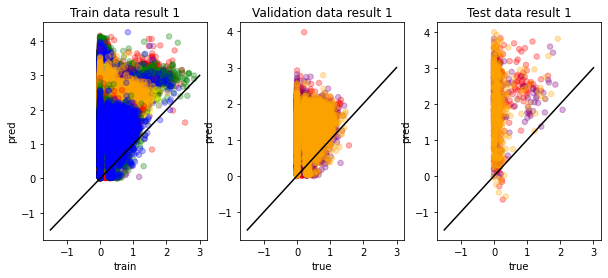

Processing protein 7
Epoch  0 Train_loss:  0.44126955  Validation_loss:  0.3733783  Test_loss:  0.36723593
Epoch  500 Train_loss:  0.26988497  Validation_loss:  0.26086652  Test_loss:  0.31460637
Epoch  1000 Train_loss:  0.2528439  Validation_loss:  0.24770206  Test_loss:  0.31996164
Epoch  1500 Train_loss:  0.23751636  Validation_loss:  0.23533148  Test_loss:  0.32325304
Epoch  2000 Train_loss:  0.2219376  Validation_loss:  0.22198184  Test_loss:  0.32779184
Epoch  2500 Train_loss:  0.20556134  Validation_loss:  0.20745474  Test_loss:  0.3334867
Epoch  3000 Train_loss:  0.1883668  Validation_loss:  0.19163771  Test_loss:  0.34026122
Epoch  3500 Train_loss:  0.17052954  Validation_loss:  0.17495462  Test_loss:  0.3451611
Epoch  4000 Train_loss:  0.15266567  Validation_loss:  0.15792356  Test_loss:  0.3503894
Epoch  4500 Train_loss:  0.13520227  Validation_loss:  0.14104931  Test_loss:  0.354948
Epoch  5000 Train_loss:  0.118881784  Validation_loss:  0.12523715  Test_loss:  0.35819575
E

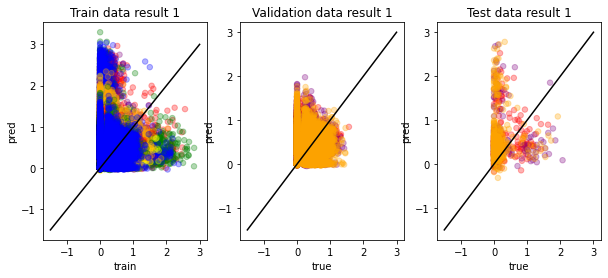

Processing protein 8
Epoch  0 Train_loss:  0.57659745  Validation_loss:  0.76686525  Test_loss:  0.3607662
Epoch  500 Train_loss:  0.27952582  Validation_loss:  0.2768252  Test_loss:  0.33797854
Epoch  1000 Train_loss:  0.2609362  Validation_loss:  0.25695536  Test_loss:  0.34010974
Epoch  1500 Train_loss:  0.24633314  Validation_loss:  0.24259163  Test_loss:  0.3450985
Epoch  2000 Train_loss:  0.23210628  Validation_loss:  0.22826111  Test_loss:  0.3487601
Epoch  2500 Train_loss:  0.21731806  Validation_loss:  0.21403266  Test_loss:  0.3533732
Epoch  3000 Train_loss:  0.20164137  Validation_loss:  0.19893157  Test_loss:  0.35735172
Epoch  3500 Train_loss:  0.18505442  Validation_loss:  0.18313168  Test_loss:  0.36106175
Epoch  4000 Train_loss:  0.16782181  Validation_loss:  0.16666669  Test_loss:  0.36404952
Epoch  4500 Train_loss:  0.15048118  Validation_loss:  0.15022941  Test_loss:  0.36678547
Epoch  5000 Train_loss:  0.13362502  Validation_loss:  0.13407543  Test_loss:  0.36840054

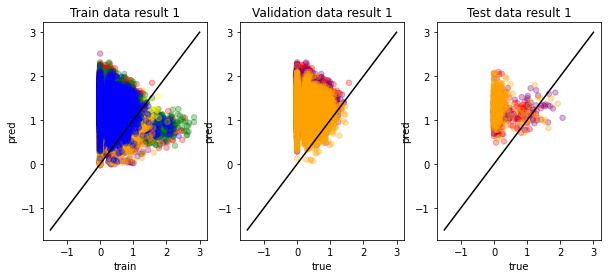

Processing protein 9
Epoch  0 Train_loss:  0.66720295  Validation_loss:  0.43279597  Test_loss:  0.85551876
Epoch  500 Train_loss:  0.347137  Validation_loss:  0.31130227  Test_loss:  0.5193933
Epoch  1000 Train_loss:  0.32165548  Validation_loss:  0.2918549  Test_loss:  0.5329441
Epoch  1500 Train_loss:  0.29792565  Validation_loss:  0.27282885  Test_loss:  0.54898334
Epoch  2000 Train_loss:  0.27245992  Validation_loss:  0.25189352  Test_loss:  0.5627597
Epoch  2500 Train_loss:  0.24466904  Validation_loss:  0.22886248  Test_loss:  0.5727043
Epoch  3000 Train_loss:  0.21527268  Validation_loss:  0.20384826  Test_loss:  0.58450156
Epoch  3500 Train_loss:  0.18596241  Validation_loss:  0.1785753  Test_loss:  0.59145314
Epoch  4000 Train_loss:  0.1581304  Validation_loss:  0.15380302  Test_loss:  0.6123978
Epoch  4500 Train_loss:  0.14265463  Validation_loss:  0.13853927  Test_loss:  0.5882218
Epoch  5000 Train_loss:  0.12786277  Validation_loss:  0.12480377  Test_loss:  0.6534805
Epoch

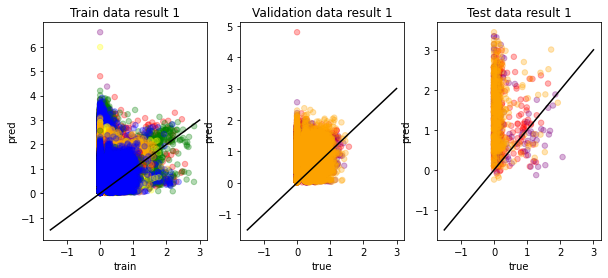

Processing protein 10
Epoch  0 Train_loss:  0.8583869  Validation_loss:  0.49102616  Test_loss:  0.99312705
Epoch  500 Train_loss:  0.31996527  Validation_loss:  0.28794858  Test_loss:  0.48530453
Epoch  1000 Train_loss:  0.28714678  Validation_loss:  0.26281342  Test_loss:  0.4918084
Epoch  1500 Train_loss:  0.26096305  Validation_loss:  0.24257694  Test_loss:  0.5009501
Epoch  2000 Train_loss:  0.23653337  Validation_loss:  0.22298074  Test_loss:  0.50637627
Epoch  2500 Train_loss:  0.212497  Validation_loss:  0.20335354  Test_loss:  0.5108604
Epoch  3000 Train_loss:  0.1889923  Validation_loss:  0.18355568  Test_loss:  0.5133824
Epoch  3500 Train_loss:  0.16607276  Validation_loss:  0.16419953  Test_loss:  0.5177553
Epoch  4000 Train_loss:  0.1448369  Validation_loss:  0.14574602  Test_loss:  0.5199958
Epoch  4500 Train_loss:  0.12531754  Validation_loss:  0.1287411  Test_loss:  0.5236658
Epoch  5000 Train_loss:  0.10814092  Validation_loss:  0.11348936  Test_loss:  0.5270506
Epoch 

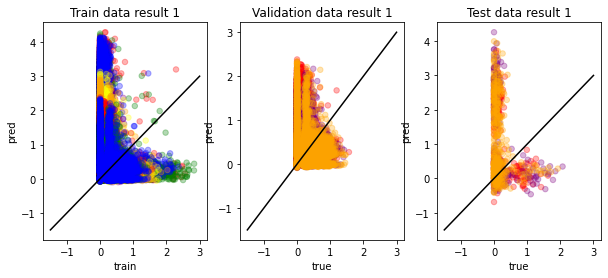

Processing protein 11
Epoch  0 Train_loss:  0.7181489  Validation_loss:  0.36208686  Test_loss:  1.253867
Epoch  500 Train_loss:  0.2958151  Validation_loss:  0.23950922  Test_loss:  0.56678534
Epoch  1000 Train_loss:  0.2542195  Validation_loss:  0.21361303  Test_loss:  0.5685167
Epoch  1500 Train_loss:  0.22419444  Validation_loss:  0.19356377  Test_loss:  0.5728369
Epoch  2000 Train_loss:  0.19765444  Validation_loss:  0.17499879  Test_loss:  0.5817738
Epoch  2500 Train_loss:  0.17310432  Validation_loss:  0.15731011  Test_loss:  0.5895973
Epoch  3000 Train_loss:  0.1505728  Validation_loss:  0.14063829  Test_loss:  0.5963898
Epoch  3500 Train_loss:  0.13035296  Validation_loss:  0.12529276  Test_loss:  0.6006894
Epoch  4000 Train_loss:  0.11262496  Validation_loss:  0.11142881  Test_loss:  0.6061232
Epoch  4500 Train_loss:  0.09750938  Validation_loss:  0.09924649  Test_loss:  0.60786116
Epoch  5000 Train_loss:  0.084652744  Validation_loss:  0.08855012  Test_loss:  0.61087346
Epoc

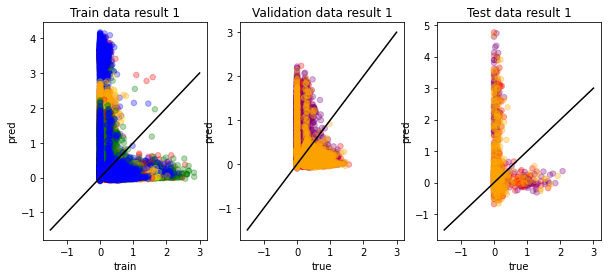

Processing protein 12
Epoch  0 Train_loss:  0.62185943  Validation_loss:  0.4896032  Test_loss:  0.6124262
Epoch  500 Train_loss:  0.3387266  Validation_loss:  0.3107854  Test_loss:  0.47750017
Epoch  1000 Train_loss:  0.30898082  Validation_loss:  0.2878869  Test_loss:  0.4672835
Epoch  1500 Train_loss:  0.2832434  Validation_loss:  0.26816106  Test_loss:  0.46274155
Epoch  2000 Train_loss:  0.25780645  Validation_loss:  0.2474786  Test_loss:  0.4622249
Epoch  2500 Train_loss:  0.23160084  Validation_loss:  0.22511962  Test_loss:  0.46591443
Epoch  3000 Train_loss:  0.20482354  Validation_loss:  0.2015417  Test_loss:  0.47050047
Epoch  3500 Train_loss:  0.17830734  Validation_loss:  0.17775117  Test_loss:  0.47450852
Epoch  4000 Train_loss:  0.15330628  Validation_loss:  0.15490828  Test_loss:  0.4786619
Epoch  4500 Train_loss:  0.13060196  Validation_loss:  0.13387424  Test_loss:  0.48343438
Epoch  5000 Train_loss:  0.110834375  Validation_loss:  0.115448415  Test_loss:  0.4860229
Ep

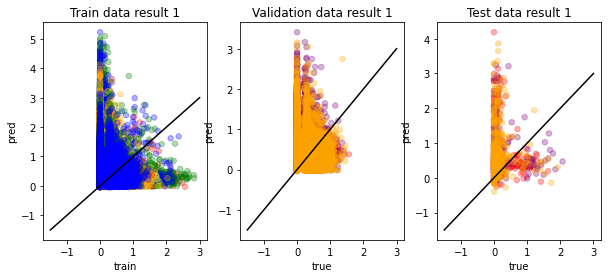

Processing protein 13
Epoch  0 Train_loss:  0.64219964  Validation_loss:  0.4106337  Test_loss:  0.85304046
Epoch  500 Train_loss:  0.2506506  Validation_loss:  0.23302431  Test_loss:  0.42191175
Epoch  1000 Train_loss:  0.22529747  Validation_loss:  0.2149882  Test_loss:  0.43305615
Epoch  1500 Train_loss:  0.20813964  Validation_loss:  0.20198746  Test_loss:  0.44512954
Epoch  2000 Train_loss:  0.19322038  Validation_loss:  0.19026718  Test_loss:  0.45647788
Epoch  2500 Train_loss:  0.17905621  Validation_loss:  0.17872699  Test_loss:  0.46632206
Epoch  3000 Train_loss:  0.16530833  Validation_loss:  0.16706726  Test_loss:  0.474411
Epoch  3500 Train_loss:  0.1518576  Validation_loss:  0.15526946  Test_loss:  0.47916242
Epoch  4000 Train_loss:  0.13880609  Validation_loss:  0.14352606  Test_loss:  0.48445222
Epoch  4500 Train_loss:  0.12627906  Validation_loss:  0.13199541  Test_loss:  0.48870945
Epoch  5000 Train_loss:  0.11439875  Validation_loss:  0.12085083  Test_loss:  0.4898819

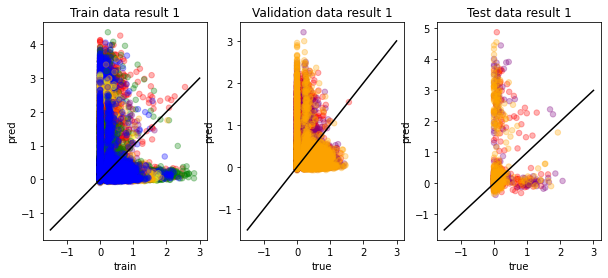

Processing protein 14
Epoch  0 Train_loss:  0.57191885  Validation_loss:  0.5371829  Test_loss:  0.5409677
Epoch  500 Train_loss:  0.24867146  Validation_loss:  0.23549397  Test_loss:  0.2880217
Epoch  1000 Train_loss:  0.22666144  Validation_loss:  0.21852003  Test_loss:  0.27996993
Epoch  1500 Train_loss:  0.2108973  Validation_loss:  0.20674488  Test_loss:  0.27654454
Epoch  2000 Train_loss:  0.19707896  Validation_loss:  0.19567794  Test_loss:  0.276183
Epoch  2500 Train_loss:  0.18388481  Validation_loss:  0.1846477  Test_loss:  0.27910167
Epoch  3000 Train_loss:  0.1709628  Validation_loss:  0.1729887  Test_loss:  0.28144243
Epoch  3500 Train_loss:  0.158164  Validation_loss:  0.16116796  Test_loss:  0.2845936
Epoch  4000 Train_loss:  0.14549139  Validation_loss:  0.1489801  Test_loss:  0.28743467
Epoch  4500 Train_loss:  0.13308577  Validation_loss:  0.13672893  Test_loss:  0.28950903
Epoch  5000 Train_loss:  0.12099232  Validation_loss:  0.12480834  Test_loss:  0.29276216
Epoch

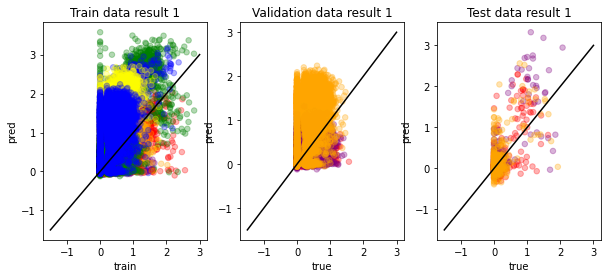

Processing protein 15
Epoch  0 Train_loss:  0.74757147  Validation_loss:  0.70846814  Test_loss:  0.61133057
Epoch  500 Train_loss:  0.28873858  Validation_loss:  0.27659717  Test_loss:  0.28584507
Epoch  1000 Train_loss:  0.26676404  Validation_loss:  0.25809318  Test_loss:  0.2925839
Epoch  1500 Train_loss:  0.24882703  Validation_loss:  0.24385352  Test_loss:  0.29736516
Epoch  2000 Train_loss:  0.23185663  Validation_loss:  0.23007454  Test_loss:  0.30083582
Epoch  2500 Train_loss:  0.21484818  Validation_loss:  0.21565633  Test_loss:  0.30454105
Epoch  3000 Train_loss:  0.19755399  Validation_loss:  0.20028093  Test_loss:  0.30703396
Epoch  3500 Train_loss:  0.17995723  Validation_loss:  0.18417437  Test_loss:  0.30921236
Epoch  4000 Train_loss:  0.16237965  Validation_loss:  0.16760503  Test_loss:  0.31177446
Epoch  4500 Train_loss:  0.1454024  Validation_loss:  0.15132469  Test_loss:  0.31189892
Epoch  5000 Train_loss:  0.12916367  Validation_loss:  0.1354621  Test_loss:  0.3181

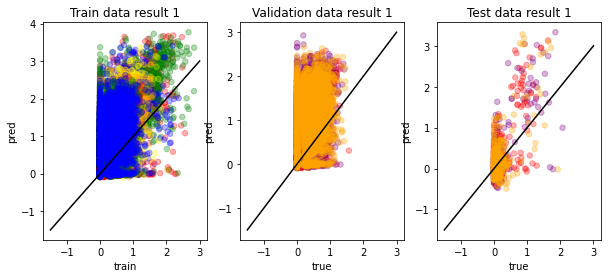

Processing protein 16
Epoch  0 Train_loss:  0.8409756  Validation_loss:  0.5835758  Test_loss:  1.3224356
Epoch  500 Train_loss:  0.39673993  Validation_loss:  0.36206976  Test_loss:  0.6041121
Epoch  1000 Train_loss:  0.35851356  Validation_loss:  0.33177185  Test_loss:  0.6117807
Epoch  1500 Train_loss:  0.32378036  Validation_loss:  0.30333403  Test_loss:  0.6172527
Epoch  2000 Train_loss:  0.28930378  Validation_loss:  0.27382922  Test_loss:  0.6298426
Epoch  2500 Train_loss:  0.25427145  Validation_loss:  0.2431383  Test_loss:  0.6502275
Epoch  3000 Train_loss:  0.21920085  Validation_loss:  0.21256784  Test_loss:  0.66678613
Epoch  3500 Train_loss:  0.18944013  Validation_loss:  0.18732852  Test_loss:  0.6503546
Epoch  4000 Train_loss:  0.16821298  Validation_loss:  0.16378967  Test_loss:  0.7263886
Epoch  4500 Train_loss:  0.16334148  Validation_loss:  0.15786296  Test_loss:  0.6366771
Epoch  5000 Train_loss:  0.15960346  Validation_loss:  0.15219101  Test_loss:  0.63401073
Epoc

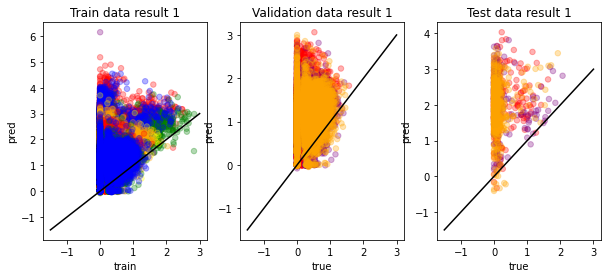

Processing protein 17
Epoch  0 Train_loss:  1.2218171  Validation_loss:  0.9242182  Test_loss:  1.2441111
Epoch  500 Train_loss:  0.523225  Validation_loss:  0.47921485  Test_loss:  0.88644534
Epoch  1000 Train_loss:  0.46620873  Validation_loss:  0.4359406  Test_loss:  0.9278262
Epoch  1500 Train_loss:  0.41057  Validation_loss:  0.3897049  Test_loss:  0.9494551
Epoch  2000 Train_loss:  0.3548111  Validation_loss:  0.34004903  Test_loss:  0.91731393
Epoch  2500 Train_loss:  0.37937  Validation_loss:  0.34897676  Test_loss:  1.2073426
Epoch  3000 Train_loss:  0.24017516  Validation_loss:  0.24329448  Test_loss:  0.99675804
Epoch  3500 Train_loss:  0.27625006  Validation_loss:  0.2553097  Test_loss:  1.1777215
Epoch  4000 Train_loss:  0.23410337  Validation_loss:  0.22100542  Test_loss:  1.1548473
Epoch  4500 Train_loss:  0.20649524  Validation_loss:  0.19590503  Test_loss:  0.8668031
Epoch  5000 Train_loss:  0.18688811  Validation_loss:  0.17117822  Test_loss:  1.1275694
Epoch  5500 Tr

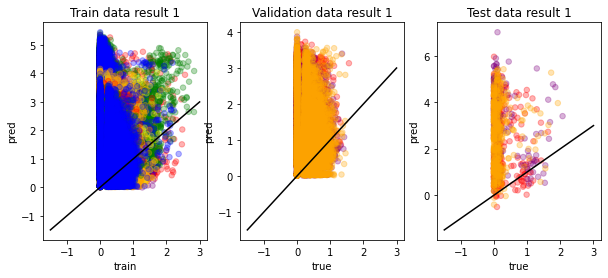

Processing protein 18
Epoch  0 Train_loss:  0.54871523  Validation_loss:  0.52518165  Test_loss:  0.69061923
Epoch  500 Train_loss:  0.27276844  Validation_loss:  0.2763633  Test_loss:  0.3465456
Epoch  1000 Train_loss:  0.24983126  Validation_loss:  0.2552397  Test_loss:  0.3489209
Epoch  1500 Train_loss:  0.23094057  Validation_loss:  0.23729984  Test_loss:  0.353108
Epoch  2000 Train_loss:  0.2134811  Validation_loss:  0.22068217  Test_loss:  0.35622156
Epoch  2500 Train_loss:  0.19653496  Validation_loss:  0.20438859  Test_loss:  0.3609309
Epoch  3000 Train_loss:  0.17966256  Validation_loss:  0.1879362  Test_loss:  0.36391768
Epoch  3500 Train_loss:  0.16302638  Validation_loss:  0.17154613  Test_loss:  0.3673675
Epoch  4000 Train_loss:  0.14659737  Validation_loss:  0.155275  Test_loss:  0.37300515
Epoch  4500 Train_loss:  0.13098767  Validation_loss:  0.13967675  Test_loss:  0.3773549
Epoch  5000 Train_loss:  0.11637218  Validation_loss:  0.12496414  Test_loss:  0.3795156
Epoch 

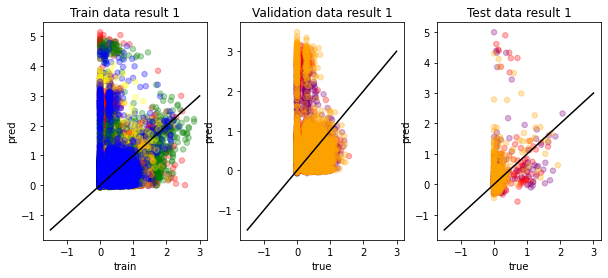

Processing protein 19
Epoch  0 Train_loss:  1.0211084  Validation_loss:  0.58747244  Test_loss:  1.3222576
Epoch  500 Train_loss:  0.35362363  Validation_loss:  0.29198557  Test_loss:  0.6191849
Epoch  1000 Train_loss:  0.3170181  Validation_loss:  0.26720348  Test_loss:  0.6237051
Epoch  1500 Train_loss:  0.28592047  Validation_loss:  0.24474826  Test_loss:  0.6346626
Epoch  2000 Train_loss:  0.25506115  Validation_loss:  0.22185355  Test_loss:  0.644611
Epoch  2500 Train_loss:  0.2239158  Validation_loss:  0.19844793  Test_loss:  0.65422314
Epoch  3000 Train_loss:  0.19357748  Validation_loss:  0.17518994  Test_loss:  0.66175437
Epoch  3500 Train_loss:  0.16423467  Validation_loss:  0.15310948  Test_loss:  0.66838944
Epoch  4000 Train_loss:  0.13848919  Validation_loss:  0.13342345  Test_loss:  0.6740225
Epoch  4500 Train_loss:  0.11623311  Validation_loss:  0.1158772  Test_loss:  0.6781304
Epoch  5000 Train_loss:  0.09776396  Validation_loss:  0.10100376  Test_loss:  0.6807903
Epoch

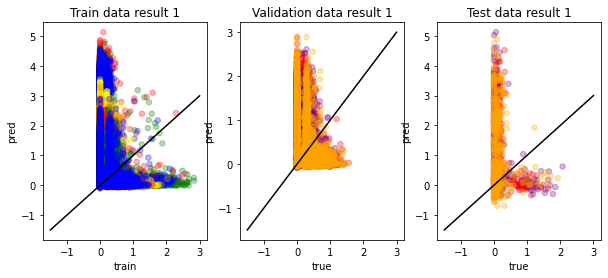

Processing protein 20
Epoch  0 Train_loss:  0.53684896  Validation_loss:  0.69815606  Test_loss:  0.44967797
Epoch  500 Train_loss:  0.28329423  Validation_loss:  0.28287792  Test_loss:  0.2948569
Epoch  1000 Train_loss:  0.2672225  Validation_loss:  0.26625344  Test_loss:  0.29295045
Epoch  1500 Train_loss:  0.25354525  Validation_loss:  0.25291026  Test_loss:  0.2937978
Epoch  2000 Train_loss:  0.23938349  Validation_loss:  0.23923016  Test_loss:  0.2970762
Epoch  2500 Train_loss:  0.22405414  Validation_loss:  0.22451986  Test_loss:  0.3016439
Epoch  3000 Train_loss:  0.20739526  Validation_loss:  0.20842446  Test_loss:  0.30629823
Epoch  3500 Train_loss:  0.1896307  Validation_loss:  0.19142121  Test_loss:  0.3115835
Epoch  4000 Train_loss:  0.1711377  Validation_loss:  0.17339654  Test_loss:  0.31579715
Epoch  4500 Train_loss:  0.1526649  Validation_loss:  0.1555445  Test_loss:  0.32017136
Epoch  5000 Train_loss:  0.13491215  Validation_loss:  0.13820352  Test_loss:  0.32413402
Ep

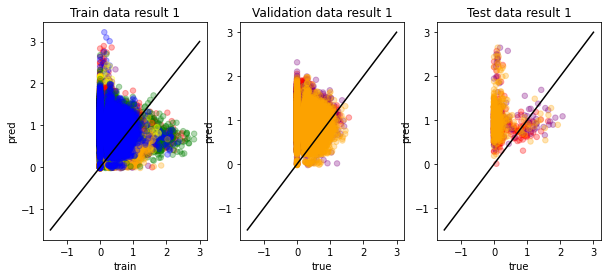

Processing protein 21
Epoch  0 Train_loss:  0.7564645  Validation_loss:  0.5054703  Test_loss:  0.5528126
Epoch  500 Train_loss:  0.4235027  Validation_loss:  0.34251493  Test_loss:  0.57297665
Epoch  1000 Train_loss:  0.38373187  Validation_loss:  0.32094243  Test_loss:  0.5787875
Epoch  1500 Train_loss:  0.34758875  Validation_loss:  0.29613093  Test_loss:  0.57987016
Epoch  2000 Train_loss:  0.30944446  Validation_loss:  0.2680604  Test_loss:  0.5973878
Epoch  2500 Train_loss:  0.26877564  Validation_loss:  0.2364163  Test_loss:  0.60029376
Epoch  3000 Train_loss:  0.22906438  Validation_loss:  0.20293722  Test_loss:  0.57285905
Epoch  3500 Train_loss:  0.2012377  Validation_loss:  0.17836764  Test_loss:  0.5484921
Epoch  4000 Train_loss:  0.16948253  Validation_loss:  0.15530373  Test_loss:  0.63197863
Epoch  4500 Train_loss:  0.13355161  Validation_loss:  0.1254711  Test_loss:  0.57462966
Epoch  5000 Train_loss:  0.25540987  Validation_loss:  0.22115684  Test_loss:  0.7856862
Epoc

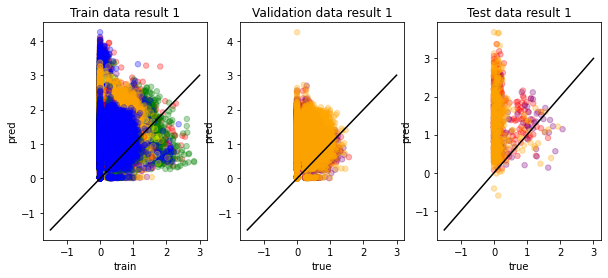

Processing protein 22
Epoch  0 Train_loss:  0.30019116  Validation_loss:  0.21287355  Test_loss:  0.33354732
Epoch  500 Train_loss:  0.22300689  Validation_loss:  0.1800294  Test_loss:  0.24705927
Epoch  1000 Train_loss:  0.20440163  Validation_loss:  0.17204183  Test_loss:  0.23712678
Epoch  1500 Train_loss:  0.18964158  Validation_loss:  0.1642555  Test_loss:  0.23563011
Epoch  2000 Train_loss:  0.176955  Validation_loss:  0.15680154  Test_loss:  0.23856634
Epoch  2500 Train_loss:  0.16523692  Validation_loss:  0.14920606  Test_loss:  0.24225058
Epoch  3000 Train_loss:  0.15390304  Validation_loss:  0.14132288  Test_loss:  0.24625753
Epoch  3500 Train_loss:  0.14275064  Validation_loss:  0.13321142  Test_loss:  0.25207943
Epoch  4000 Train_loss:  0.13173671  Validation_loss:  0.12475184  Test_loss:  0.2553045
Epoch  4500 Train_loss:  0.121009015  Validation_loss:  0.11624498  Test_loss:  0.25864074
Epoch  5000 Train_loss:  0.11054993  Validation_loss:  0.10779517  Test_loss:  0.26406

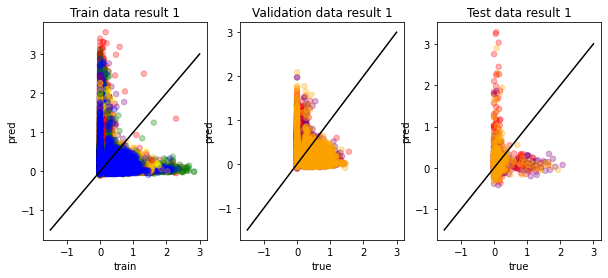

Processing protein 23
Epoch  0 Train_loss:  0.7714919  Validation_loss:  0.41556427  Test_loss:  0.7751146
Epoch  500 Train_loss:  0.3245298  Validation_loss:  0.2815663  Test_loss:  0.41452178
Epoch  1000 Train_loss:  0.28313857  Validation_loss:  0.25597626  Test_loss:  0.4257778
Epoch  1500 Train_loss:  0.2540035  Validation_loss:  0.23471864  Test_loss:  0.43311313
Epoch  2000 Train_loss:  0.22783819  Validation_loss:  0.2147007  Test_loss:  0.4403618
Epoch  2500 Train_loss:  0.20283808  Validation_loss:  0.19481274  Test_loss:  0.44920775
Epoch  3000 Train_loss:  0.17878175  Validation_loss:  0.1747653  Test_loss:  0.45572615
Epoch  3500 Train_loss:  0.15608929  Validation_loss:  0.15518981  Test_loss:  0.45952278
Epoch  4000 Train_loss:  0.13517119  Validation_loss:  0.1367608  Test_loss:  0.46459475
Epoch  4500 Train_loss:  0.11709264  Validation_loss:  0.12034423  Test_loss:  0.47027606
Epoch  5000 Train_loss:  0.100053936  Validation_loss:  0.104799286  Test_loss:  0.47271857


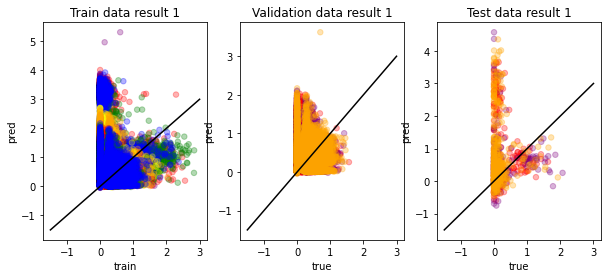

Processing protein 24
Epoch  0 Train_loss:  0.78712034  Validation_loss:  0.571259  Test_loss:  1.0442998
Epoch  500 Train_loss:  0.3926793  Validation_loss:  0.35330978  Test_loss:  0.634274
Epoch  1000 Train_loss:  0.35451078  Validation_loss:  0.32368636  Test_loss:  0.6351737
Epoch  1500 Train_loss:  0.3206772  Validation_loss:  0.2964975  Test_loss:  0.6331988
Epoch  2000 Train_loss:  0.2865847  Validation_loss:  0.26647943  Test_loss:  0.65636134
Epoch  2500 Train_loss:  0.25266284  Validation_loss:  0.23752064  Test_loss:  0.6705008
Epoch  3000 Train_loss:  0.21887007  Validation_loss:  0.20867874  Test_loss:  0.6793779
Epoch  3500 Train_loss:  0.21279271  Validation_loss:  0.20247933  Test_loss:  0.6213322
Epoch  4000 Train_loss:  0.16147973  Validation_loss:  0.15833032  Test_loss:  0.70328283
Epoch  4500 Train_loss:  0.15749428  Validation_loss:  0.15287271  Test_loss:  0.6451341
Epoch  5000 Train_loss:  0.12514594  Validation_loss:  0.12645407  Test_loss:  0.680913
Epoch  55

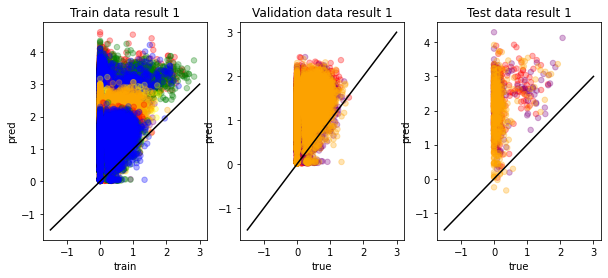

Processing protein 25
Epoch  0 Train_loss:  0.4573137  Validation_loss:  0.46908456  Test_loss:  0.3212923
Epoch  500 Train_loss:  0.23771161  Validation_loss:  0.25342992  Test_loss:  0.18965815
Epoch  1000 Train_loss:  0.22467558  Validation_loss:  0.24170107  Test_loss:  0.18852879
Epoch  1500 Train_loss:  0.21420549  Validation_loss:  0.2316491  Test_loss:  0.1909548
Epoch  2000 Train_loss:  0.20396404  Validation_loss:  0.22130921  Test_loss:  0.1949061
Epoch  2500 Train_loss:  0.19335572  Validation_loss:  0.21040073  Test_loss:  0.19932713
Epoch  3000 Train_loss:  0.18214962  Validation_loss:  0.19866696  Test_loss:  0.20401652
Epoch  3500 Train_loss:  0.17033494  Validation_loss:  0.18621723  Test_loss:  0.20898949
Epoch  4000 Train_loss:  0.15797551  Validation_loss:  0.17307782  Test_loss:  0.2135296
Epoch  4500 Train_loss:  0.14529815  Validation_loss:  0.15956593  Test_loss:  0.21809311
Epoch  5000 Train_loss:  0.1325558  Validation_loss:  0.14596471  Test_loss:  0.22262393

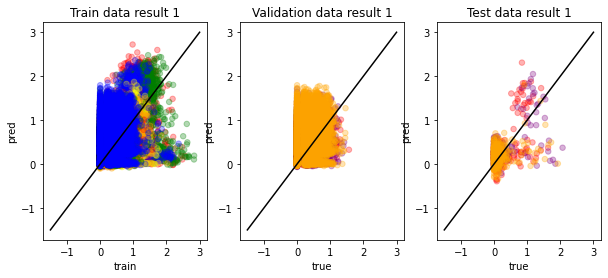

Processing protein 26
Epoch  0 Train_loss:  0.650365  Validation_loss:  0.43080267  Test_loss:  0.9526628
Epoch  500 Train_loss:  0.2846909  Validation_loss:  0.27139652  Test_loss:  0.4213203
Epoch  1000 Train_loss:  0.2523909  Validation_loss:  0.24356447  Test_loss:  0.42095205
Epoch  1500 Train_loss:  0.22874275  Validation_loss:  0.22376828  Test_loss:  0.42479768
Epoch  2000 Train_loss:  0.20826584  Validation_loss:  0.20674117  Test_loss:  0.43210316
Epoch  2500 Train_loss:  0.18933482  Validation_loss:  0.19057648  Test_loss:  0.43908042
Epoch  3000 Train_loss:  0.17146045  Validation_loss:  0.17482048  Test_loss:  0.4442736
Epoch  3500 Train_loss:  0.1545695  Validation_loss:  0.15967661  Test_loss:  0.4506088
Epoch  4000 Train_loss:  0.13874345  Validation_loss:  0.14520936  Test_loss:  0.45585567
Epoch  4500 Train_loss:  0.12414794  Validation_loss:  0.13165395  Test_loss:  0.46123648
Epoch  5000 Train_loss:  0.11077497  Validation_loss:  0.119086884  Test_loss:  0.4650633
E

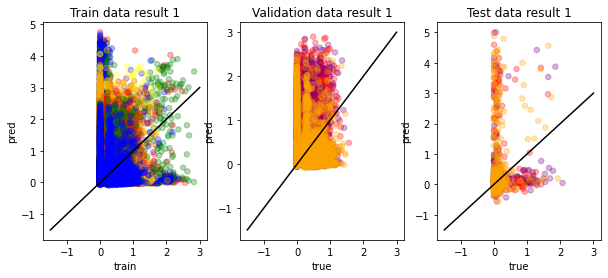

Processing protein 27
Epoch  0 Train_loss:  0.22837923  Validation_loss:  0.20015207  Test_loss:  0.23843327
Epoch  500 Train_loss:  0.19435266  Validation_loss:  0.17525065  Test_loss:  0.18930992
Epoch  1000 Train_loss:  0.18519194  Validation_loss:  0.17044513  Test_loss:  0.18467285
Epoch  1500 Train_loss:  0.1773489  Validation_loss:  0.16573106  Test_loss:  0.18370496
Epoch  2000 Train_loss:  0.16967581  Validation_loss:  0.16054668  Test_loss:  0.18464795
Epoch  2500 Train_loss:  0.1618012  Validation_loss:  0.15469114  Test_loss:  0.18614738
Epoch  3000 Train_loss:  0.15354429  Validation_loss:  0.14820826  Test_loss:  0.18850312
Epoch  3500 Train_loss:  0.1448642  Validation_loss:  0.14104876  Test_loss:  0.19082044
Epoch  4000 Train_loss:  0.13581279  Validation_loss:  0.13335183  Test_loss:  0.19368848
Epoch  4500 Train_loss:  0.12647696  Validation_loss:  0.12518837  Test_loss:  0.1959622
Epoch  5000 Train_loss:  0.116971515  Validation_loss:  0.11677041  Test_loss:  0.1988

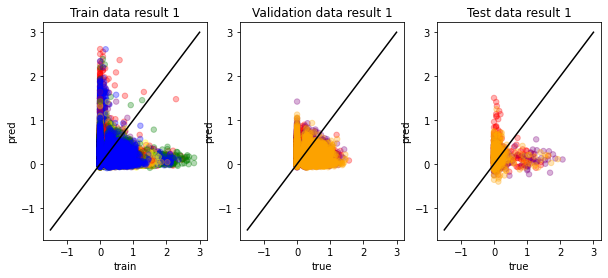

Processing protein 28
Epoch  0 Train_loss:  0.69495296  Validation_loss:  0.58709276  Test_loss:  0.89027476
Epoch  500 Train_loss:  0.37825346  Validation_loss:  0.3155184  Test_loss:  0.49179658
Epoch  1000 Train_loss:  0.3408322  Validation_loss:  0.29217523  Test_loss:  0.4959257
Epoch  1500 Train_loss:  0.30994835  Validation_loss:  0.2717578  Test_loss:  0.5081559
Epoch  2000 Train_loss:  0.2798382  Validation_loss:  0.25018805  Test_loss:  0.5209252
Epoch  2500 Train_loss:  0.2490154  Validation_loss:  0.22681431  Test_loss:  0.53357375
Epoch  3000 Train_loss:  0.21755528  Validation_loss:  0.20208156  Test_loss:  0.54425204
Epoch  3500 Train_loss:  0.1869414  Validation_loss:  0.17708553  Test_loss:  0.5530337
Epoch  4000 Train_loss:  0.15908386  Validation_loss:  0.1539405  Test_loss:  0.55925024
Epoch  4500 Train_loss:  0.13253464  Validation_loss:  0.13155402  Test_loss:  0.5660155
Epoch  5000 Train_loss:  0.15297675  Validation_loss:  0.14314432  Test_loss:  0.57774353
Epoc

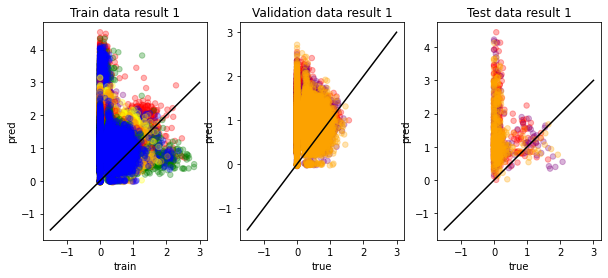

Processing protein 29
Epoch  0 Train_loss:  0.5333955  Validation_loss:  0.6566646  Test_loss:  0.40185982
Epoch  500 Train_loss:  0.30669287  Validation_loss:  0.28604397  Test_loss:  0.29693463
Epoch  1000 Train_loss:  0.28618312  Validation_loss:  0.2703385  Test_loss:  0.30478248
Epoch  1500 Train_loss:  0.26868168  Validation_loss:  0.25614145  Test_loss:  0.3148843
Epoch  2000 Train_loss:  0.25091517  Validation_loss:  0.24104752  Test_loss:  0.32491615
Epoch  2500 Train_loss:  0.23189797  Validation_loss:  0.22388384  Test_loss:  0.33513194
Epoch  3000 Train_loss:  0.21134458  Validation_loss:  0.20571463  Test_loss:  0.3442221
Epoch  3500 Train_loss:  0.18972981  Validation_loss:  0.18607882  Test_loss:  0.35236663
Epoch  4000 Train_loss:  0.16790253  Validation_loss:  0.16629095  Test_loss:  0.3590656
Epoch  4500 Train_loss:  0.14671794  Validation_loss:  0.14643343  Test_loss:  0.36707324
Epoch  5000 Train_loss:  0.12678395  Validation_loss:  0.12828636  Test_loss:  0.3707766

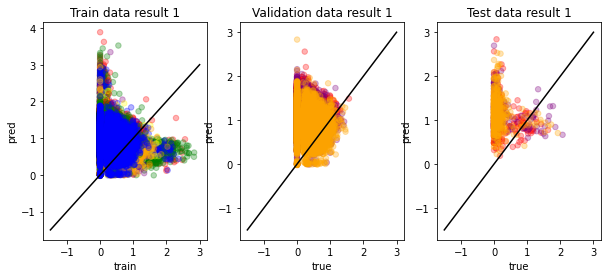

Processing protein 30
Epoch  0 Train_loss:  0.44628567  Validation_loss:  0.5046635  Test_loss:  0.42158255
Epoch  500 Train_loss:  0.3010289  Validation_loss:  0.28323746  Test_loss:  0.289224
Epoch  1000 Train_loss:  0.28104413  Validation_loss:  0.26792917  Test_loss:  0.2895844
Epoch  1500 Train_loss:  0.2634496  Validation_loss:  0.2543133  Test_loss:  0.29778123
Epoch  2000 Train_loss:  0.24560708  Validation_loss:  0.23926444  Test_loss:  0.30629256
Epoch  2500 Train_loss:  0.22668764  Validation_loss:  0.22286211  Test_loss:  0.3159674
Epoch  3000 Train_loss:  0.20640486  Validation_loss:  0.2045501  Test_loss:  0.32470915
Epoch  3500 Train_loss:  0.18514247  Validation_loss:  0.18538581  Test_loss:  0.33289963
Epoch  4000 Train_loss:  0.16412231  Validation_loss:  0.16558751  Test_loss:  0.34033588
Epoch  4500 Train_loss:  0.14285967  Validation_loss:  0.14633761  Test_loss:  0.34547624
Epoch  5000 Train_loss:  0.12356446  Validation_loss:  0.12830864  Test_loss:  0.35011548
E

In [ ]:
results = []
    
for i in range(train_output.shape[1]):
    print(f'Processing protein {i}')
    model = Autoencoder()
    opt = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
    model = model.to(device)
    temp = fit(num_epochs, model, loss_fn, i, train_input, train_output, val_input, val_output, test_input, test_output)
    results.append([i]+temp)

In [ ]:
results